In [8]:
# adding baseline drift correction for correlation signal

import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt
%matplotlib inline
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.signal import medfilt

from skimage.draw import rectangle_perimeter
from skimage import color


def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = fs*0.5
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# https://www.py4u.net/discuss/14342
def loops_fill(arr):
    out = arr.copy()
    for row_idx in range(1,out.shape[0]):
            if np.isnan(out[row_idx]):
                out[row_idx] = out[row_idx-1]
    return out

def landmark_detection(flow_trace,corr_trace,cord_trace,beat_count):
    starts, contracts, relaxs, ends = [], [], [], []
  
    
    ###balances,balances_right = balance_point_detection(corr_trace,beat_count)
    balances = balance_point_detection1(corr_trace,beat_count)
    
    dist_inter = round(len(corr_trace)/(len(balances)+1))
    
    leftWid = round(dist_inter*2.6)
    rightWid = round(dist_inter*2.0)
    
    contracts = local_extreme_detection(flow_trace,balances,leftWid,0)
    relaxs = local_extreme_detection(flow_trace,balances,0,rightWid)
    
    starts = starts_detection(flow_trace,contracts)
    
    ends= ends_detection(flow_trace,relaxs)
    
    return starts, contracts, balances,relaxs,ends

def balance_point_detection(corr_trace,beat_count):        
        
    corr_trace_inv = 1-corr_trace
    corr_trace_inv = (corr_trace_inv-np.min(corr_trace_inv))/(np.max(corr_trace_inv)-np.min(corr_trace_inv))
    dist_inter = round(len(corr_trace)/(beat_count+1))
    
    balances_inv, prop_inv = find_peaks(corr_trace_inv, height= 1.0*0.6,distance=dist_inter)
    ###if balances.size>0:
    results_inv = peak_widths(corr_trace_inv,balances_inv)
    peak_wid_inv = (np.median(results_inv[0]))
    
    corr_trace_norm = (corr_trace-np.min(corr_trace))/(np.max(corr_trace)-np.min(corr_trace))
    balances_norm, prop_norm = find_peaks(corr_trace_norm, height= 1.0*0.8,distance=dist_inter) 
    results_norm = peak_widths(corr_trace_norm,balances_norm)
    peak_wid_norm = (np.median(results_norm[0]))    
    
    balances = balances_inv
    balances_right= results_inv[3].astype(int)
    if peak_wid_inv>peak_wid_norm and peak_wid_inv>0.6*dist_inter: # the peak width is too large, then do not need to reverse the correlation curve
        balances = balances_norm
        balances_right=results_norm[3].astype(int)

    ###print("peak width inv: " + str(peak_wid_inv))
    ###print("peak width norm: " + str(peak_wid_norm))
    ###print("dist: " + str(dist_inter))
    ###print("blances: " + str(balances))
    ###print("right: " + str(balances_right))
    return balances,balances_right
    
def balance_point_detection1(flow_trace1,beat_count):        
        

    dist_inter = round(len(flow_trace1)/(beat_count+1))
    heightMax = np.max(flow_trace1)
    
    balances, prop = find_peaks(flow_trace1, height= heightMax*0.8,distance=dist_inter)
    ###if balances.size>0:


    ###print("peak width inv: " + str(peak_wid_inv))
    ###print("peak width norm: " + str(peak_wid_norm))
    ###print("dist: " + str(dist_inter))
    ###print("blances: " + str(balances))
    ###print("right: " + str(balances_right))
    return balances+15

def local_extreme_detection(flow_trace, balances, leftWid, rightWid):
    res = []
    dist_inter = round(len(corr_trace)/(len(balances)+1))
    for bp in balances:
        leftP = max(0,bp-leftWid)
        rightP = min(len(flow_trace)-1,bp+rightWid)
        extremPs, _ = find_peaks(flow_trace[leftP:rightP],distance=dist_inter)
       
        if extremPs.size>0:
            res.append(extremPs[0]+leftP+1)
            ###res.extend(extremPs+leftP+1)
        else:
            res.append(None)
    return np.array(res)
    
def starts_detection(flow_trace,contracts):
    res = []
    count = 0
    for con in contracts:
        count = count + 1
        if not con:
            res.append(None)
            continue
        else:
            kk = 2
            lp_o = con-kk
            lp_l = lp_o-1
            lp_r = lp_o+1
            while lp_l>0: 
                lp_o = lp_o-1
                lp_l = lp_o-1
                lp_r = lp_o+1
                
                if flow_trace[lp_r]>flow_trace[lp_o] and flow_trace[lp_o]<flow_trace[lp_l]:
                    res.append(lp_o)
                    break
            if len(res)<count:
                res.append(None)
    return res

def ends_detection(flow_trace,relaxs):
    res = []
    count = 0
    for rel in relaxs:
        count = count+1
        if not rel:
            res.append(None)
            continue
        else:
            kk = 2
            rp_o = rel+kk
            rp_l = rp_o-1
            rp_r = rp_o+1
            while rp_r<len(flow_trace)-2: 
                rp_o = rp_o+1
                rp_l = rp_o-1
                rp_r = rp_o+1
                
                
                right_dist = abs(flow_trace[rp_r]-flow_trace[rp_o])
                
                if flow_trace[rp_l]>flow_trace[rp_o] and flow_trace[rp_o]<flow_trace[rp_r]:
                    res.append(rp_o)
                    break
            if len(res)<count:
                res.append(None)
                
    return res

def display_freq_componet(flow_trace,corr_trace,cord_trace,freq):
    
    LEN  = len(flow_trace)
    
    flow_fft = np.fft.fft(flow_trace)/LEN           
    flow_fft = flow_fft[range(int(LEN/2))] # Exclude sampling frequency

    corr_fft = np.fft.fft(corr_trace)/LEN           
    corr_fft = corr_fft[range(int(LEN/2))] # Exclude sampling frequency

    cord_fft = np.fft.fft(cord_trace)/LEN  
    cord_fft = cord_fft[range(int(LEN/2))] # Exclude sampling frequency
        
    
    fig, axs = plt.subplots(2,3,figsize=(15,8))
    axs[0,0].plot(flow_trace)
    axs[0,0].set_title('optical trace')

    axs[0,1].plot(corr_trace)
    axs[0,1].set_title('corr trace')

    axs[0,2].plot(abs(cord_trace))
    axs[0,2].set_title('corr diff trace')

    axs[1,0].plot(freq[1:200],abs(flow_fft[1:200]))
    axs[1,0].set_title('optical trace FFT')

    axs[1,1].plot(freq[1:200],abs(corr_fft[1:200]))
    axs[1,1].set_title('correlation trace FFT')

    axs[1,2].plot(freq[1:200],abs(cord_fft[1:200]))
    axs[1,2].set_title('correlation difftrace FFT')
    
def landmark_visualization(flow_trace0,flow_trace,corr_trace,cord_trace,beat_count,starts,contracts,balances,relaxs,ends):
    
    cordd_trace = np.diff(cord_trace, prepend=cord_trace[0])
    
    fig, axs = plt.subplots(4,figsize=(18,8))
    
    axs[0].plot(flow_trace0)
    axs[0].plot(starts,flow_trace0[starts],">", markersize=8)
    axs[0].plot(contracts,flow_trace0[contracts],"o", markersize=8)
    axs[0].plot(balances,flow_trace0[balances],"d", markersize=8)
    axs[0].plot(relaxs,flow_trace0[relaxs],"x", markersize=8)
    axs[0].plot(ends,flow_trace0[ends],"<", markersize=8)
    axs[0].set_title('optical trace')
    
    axs[1].plot(flow_trace)
    axs[1].plot(starts,flow_trace[starts],">", markersize=8)
    axs[1].plot(contracts,flow_trace[contracts],"o", markersize=8)
    axs[1].plot(balances,flow_trace[balances],"d", markersize=8)
    axs[1].plot(relaxs,flow_trace[relaxs],"x", markersize=8)
    axs[1].plot(ends,flow_trace[ends],"<", markersize=8)
    axs[1].set_title('smoothed optical trace')

    axs[2].plot(1-corr_trace)
    axs[2].plot(starts,1-corr_trace[starts],">", markersize=8)
    axs[2].plot(contracts,1-corr_trace[contracts],"o", markersize=8)
    axs[2].plot(balances,1-corr_trace[balances],"d", markersize=8)
    axs[2].plot(relaxs,1-corr_trace[relaxs],"x", markersize=8)
    axs[2].plot(ends,1-corr_trace[ends],"<", markersize=8)
    axs[2].set_title('inverse of corr trace')

    axs[3].plot(abs(cord_trace))
    axs[3].plot(starts,abs(cord_trace[starts]),">", markersize=8)
    axs[3].plot(contracts,abs(cord_trace[contracts]),"o", markersize=8)
    axs[3].plot(balances,abs(cord_trace[balances]),"d", markersize=8)
    axs[3].plot(relaxs,abs(cord_trace[relaxs]),"x", markersize=8)
    axs[3].plot(ends,abs(cord_trace[ends]),"<", markersize=8)
    axs[3].set_title('corr diff trace')
    
    return fig
    
    
def landmark_visualization_patch(flow_trace0,flow_trace,corr_trace,cord_trace,beat_count,starts,contracts,
                                 balances,relaxs,ends,regionBox,regionPix,img):
    
    cordd_trace = np.diff(cord_trace, prepend=cord_trace[0])
    
    
    alpha=0.9
    mask_region = np.zeros(img.shape[0:2])
    mask_region[regionPix[:,0],regionPix[:,1]] = 1
    
    x,y,w,h = regionBox
    rr, cc = rectangle_perimeter(start=(x,y), end=(x+w,y+h), shape=img.shape[0:2])

    frame_disp = img
    img_hsv = color.rgb2hsv(frame_disp)
    color_mask = np.zeros(frame_disp.shape)
    color_mask[...,0] = mask_region.astype(float)*255
    color_mask[...,1] = mask_region.astype(float)*255
    #color_mask[...,2] = magMask.astype(np.float)*255
    color_mask_hsv = color.rgb2hsv(color_mask)

    img_hsv[..., 0] = color_mask_hsv[..., 0]
    img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha
    img_masked = color.hsv2rgb(img_hsv)
    img_masked[rr,cc,:]=255

    
    inner = [['innerA'],
             ['innerB'],
            ['innerC'],
            ['innerD']]
    outer = [['upper left',  inner]]
    
    fig, axd = plt.subplot_mosaic(outer, constrained_layout=True, figsize=(30, 12))
 
    axd['upper left'].imshow(img_masked)

    axd['innerA'].plot(flow_trace0)
    axd['innerA'].plot(starts,flow_trace0[starts],">", markersize=8)
    axd['innerA'].plot(contracts,flow_trace0[contracts],"o", markersize=8)
    axd['innerA'].plot(balances,flow_trace0[balances],"d", markersize=8)
    axd['innerA'].plot(relaxs,flow_trace0[relaxs],"x", markersize=8)
    axd['innerA'].plot(ends,flow_trace0[ends],"<", markersize=8)
    axd['innerA'].set_title('optical trace')

    axd['innerB'].plot(flow_trace)
    axd['innerB'].plot(starts,flow_trace[starts],">", markersize=8)
    axd['innerB'].plot(contracts,flow_trace[contracts],"o", markersize=8)
    axd['innerB'].plot(balances,flow_trace[balances],"d", markersize=8)
    axd['innerB'].plot(relaxs,flow_trace[relaxs],"x", markersize=8)
    axd['innerB'].plot(ends,flow_trace[ends],"<", markersize=8)
    axd['innerB'].set_title('smoothed optical trace')

    axd['innerC'].plot(1-corr_trace)
    axd['innerC'].plot(starts,1-corr_trace[starts],">", markersize=8)
    axd['innerC'].plot(contracts,1-corr_trace[contracts],"o", markersize=8)
    axd['innerC'].plot(balances,1-corr_trace[balances],"d", markersize=8)
    axd['innerC'].plot(relaxs,1-corr_trace[relaxs],"x", markersize=8)
    axd['innerC'].plot(ends,1-corr_trace[ends],"<", markersize=8)
    axd['innerC'].set_title(['inverse of corr trace beat count: ', str(beat_count)])

    axd['innerD'].plot(abs(cord_trace))
    axd['innerD'].plot(starts,abs(cord_trace[starts]),">", markersize=8)
    axd['innerD'].plot(contracts,abs(cord_trace[contracts]),"o", markersize=8)
    axd['innerD'].plot(balances,abs(cord_trace[balances]),"d", markersize=8)
    axd['innerD'].plot(relaxs,abs(cord_trace[relaxs]),"x", markersize=8)
    axd['innerD'].plot(ends,abs(cord_trace[ends]),"<", markersize=8)
    axd['innerD'].set_title('corr diff trace')
    
    return fig    

def pair_markers(starts, contracts, balances, relaxs, ends):
        
    starts1, contracts1, balances1,relaxs1,ends1 = [],[],[],[],[]
        
    for ii in range(len(starts)):
        if starts[ii] and contracts[ii] and balances[ii] and relaxs[ii] and ends[ii]:
            starts1.append(starts[ii])
            contracts1.append(contracts[ii])
            balances1.append(balances[ii])
            relaxs1.append(relaxs[ii])
            ends1.append(ends[ii])

    ###### using list comprehension to remove None values in list        
    ###starts = [i for i in starts if i]
    ###contracts = [i for i in contracts if i]
    ###balances = [i for i in balances if i]
    ###relaxs = [i for i in relaxs if i]
    ###ends = [i for i in ends if i]

    return starts1, contracts1, balances1, relaxs1, ends1

starts
[]
contracts
[]
balances
[]
relaxs
[]
ends
[]
starts
[25, 25, 25, 134, 193, 193, 252]
contracts
[28, 28, 33, 138, 198, 203, 255]
balances
[43, 100, 154, 213, 270, 325, 379]
relaxs
[85, 138, 198, 255, 309, 363, 417]
ends
[91, 141, 201, 260, 312, 366, 422]


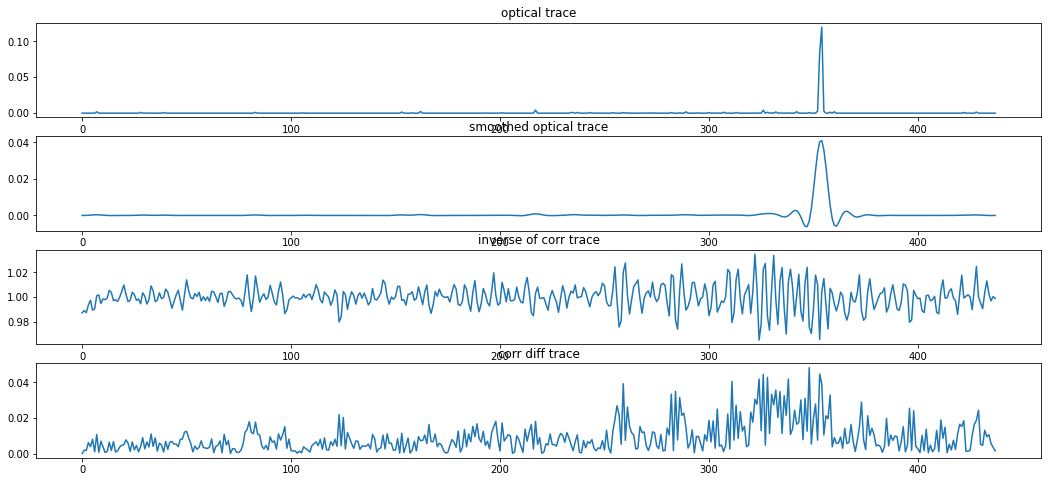

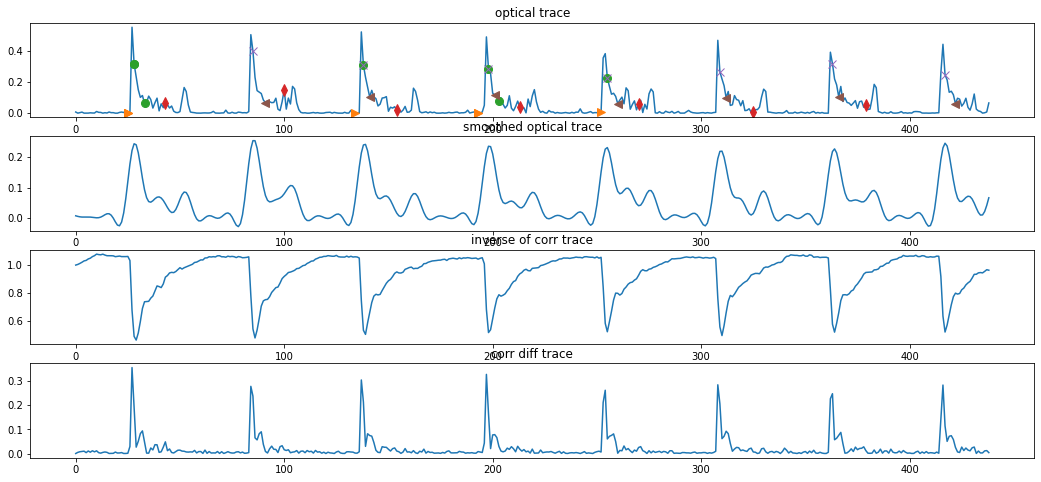

In [12]:
if __name__ == "__main__":
    
    ###rootFolder = r'../MYBPC3_dataset/data1011_Plates1_2_trace/*.npz'
    ###rootFolder = r'../MYBPC3_dataset/data1011_Plates1_2_trace_downsample/*.npz'
    ###rootFolder = r'../MYBPC3_dataset/data1025_Plate3_trace/*.npz'
    ###rootFolder = r'../MYBPC3_dataset/data1020_Plates1_9_trace/*.npz'
    ###outputFolder = r'../MYBPC3_dataset/data1011_Plates1_2_trace_annotation'
    ###outputFolder = r'../MYBPC3_dataset/data1011_Plates1_2_trace_annotation_downsample'
    ###outputFolder = r'../MYBPC3_dataset/data1025_Plate3_trace_annotation'
    ###outputFolder = r'../MYBPC3_dataset/data1020_Plates1_9_trace_annotation_new'
    
    ###rootFolder =  r'../MYBPC3_dataset/20220221_iCells_Patterned_Dishes_DataSetAnalysis/220221_ICells_Mattek_Dish_1_output/*.npz'
    ###outputFolder =r'../MYBPC3_dataset/20220221_iCells_Patterned_Dishes_DataSetAnalysis/220221_ICells_Mattek_Dish_1_annotation'
    
    ###rootFolder =  r'../MYBPC3_dataset/20220221_iCells_Patterned_Dishes_DataSetAnalysis/220221_ICells_Mattek_Dish_1_ds_output/*.npz'
    ###outputFolder =r'../MYBPC3_dataset/20220221_iCells_Patterned_Dishes_DataSetAnalysis/220221_ICells_Mattek_Dish_1_ds_annotation'

    ###rootFolder = r'Z:\pangj05\RDRU_MYBPC3_2022\0221_iCells_Patterned_Dishes_DataSetAnalysis\220221_ICells_Mattek_Dish_1_output_50Hz_Shrink19\*.npz'
    ###outputFolder = r'Z:\pangj05\RDRU_MYBPC3_2022\0221_iCells_Patterned_Dishes_DataSetAnalysis\220221_ICells_Mattek_Dish_1_output_50Hz_Shrink19_annotation'

    rootFolder = r'Z:\pangj05\RDRU_MYBPC3_2022\0511_iPSC_CM_single_cell_DataSetAnalysis\Plate_15_output\*.npz'
    outputFolder = r'Z:\pangj05\RDRU_MYBPC3_2022\0511_iPSC_CM_single_cell_DataSetAnalysis\Plate_15_output_annotation'
        
    if not os.path.isdir(outputFolder):
        print('The OUTPUT directory is not present. Creating a new one..')
        os.mkdir(outputFolder)
    
    fileNames = sorted(glob.glob(rootFolder))
    fileNum = len(fileNames)
    
    for file in fileNames[0:2]:
        
        ### load data and preprocessing (truncation and fill up NaN values)
        (dirName,filename) = os.path.split(file)
        
        data = np.load(file)
          
        flow_trace = data['optical_flow_trace']
        corr_trace = data['similary_measure']
        
        regionBox = data['regionBox']
        regionPix = data['regionPix']
        
         ## added 
        corr_trace_m = medfilt(corr_trace,71)
        corr_trace =  corr_trace-corr_trace_m 
        
        START = 25
        END = len(flow_trace)-25
        Fs = 50 # sampling frequeny 100 Hz

        flow_trace = flow_trace[START:END]
        corr_trace = corr_trace[START:END]

        flow_trace = loops_fill(flow_trace)
        corr_trace = loops_fill(corr_trace)


        cord_trace = np.diff(corr_trace, prepend=corr_trace[0])

        LEN = len(flow_trace)

        ### Filtering out noises
     
        values = np.arange(int(LEN/2))
        timePeriod  = LEN/Fs
        freq = values/timePeriod
        
        if 0:
            display_freq_componet(flow_trace,corr_trace,cord_trace,freq)
            
        flow_trace1 = butter_lowpass_filter(flow_trace, 5, Fs, 5)
        corr_trace1 = butter_lowpass_filter(corr_trace, 5, Fs, 5)
        cord_trace1 = butter_lowpass_filter(cord_trace, 5, Fs, 5)

        if 0:
            display_freq_componet(flow_trace1,corr_trace1,cord_trace1,freq)
            
        # Estimate the beating count
        flow_fft1 = np.fft.fft(flow_trace1)/LEN           
        flow_fft1 = flow_fft1[range(int(LEN/2))] # Exclude sampling frequency
        freq_ind = np.argmax(abs(flow_fft1[1:200]))
        beat_count = freq[1+freq_ind]*LEN/Fs
        
        starts, contracts, balances, relaxs, ends = landmark_detection(flow_trace,flow_trace1,
                                                                       cord_trace,beat_count)
        
        starts, contracts, balances, relaxs, ends = pair_markers(starts, contracts, balances, relaxs, ends)
  
        print("starts")
        print(starts)
        
        print("contracts")
        print(contracts)
        
        print("balances")
        print(balances)
        
        print("relaxs")
        print(relaxs)
        
        print("ends")
        print(ends)
    
        fig, axs = plt.subplots(4,figsize=(18,8))
    
        axs[0].plot(flow_trace)
        axs[0].plot(starts,flow_trace[starts],">", markersize=8)
        axs[0].plot(contracts,flow_trace[contracts],"o", markersize=8)
        axs[0].plot(balances,flow_trace[balances],"d", markersize=8)
        axs[0].plot(relaxs,flow_trace[relaxs],"x", markersize=8)
        axs[0].plot(ends,flow_trace[ends],"<", markersize=8)
        axs[0].set_title('optical trace')

        axs[1].plot(flow_trace1)
        ###axs[1].plot(starts,flow_trace[starts],">", markersize=8)
        ###axs[1].plot(contracts,flow_trace[contracts],"o", markersize=8)
        ###axs[1].plot(balances,flow_trace[balances],"d", markersize=8)
        ###axs[1].plot(relaxs,flow_trace[relaxs],"x", markersize=8)
        ###axs[1].plot(ends,flow_trace[ends],"<", markersize=8)
        axs[1].set_title('smoothed optical trace')

        axs[2].plot(1-corr_trace)
        ###axs[2].plot(starts,1-corr_trace[starts],">", markersize=8)
        ###axs[2].plot(contracts,1-corr_trace[contracts],"o", markersize=8)
        ###axs[2].plot(balances,1-corr_trace[balances],"d", markersize=8)
        ###axs[2].plot(relaxs,1-corr_trace[relaxs],"x", markersize=8)
        ###axs[2].plot(ends,1-corr_trace[ends],"<", markersize=8)
        axs[2].set_title('inverse of corr trace')

        axs[3].plot(abs(cord_trace))
        ###axs[3].plot(starts,abs(cord_trace[starts]),">", markersize=8)
        ###axs[3].plot(contracts,abs(cord_trace[contracts]),"o", markersize=8)
        ###axs[3].plot(balances,abs(cord_trace[balances]),"d", markersize=8)
        ###axs[3].plot(relaxs,abs(cord_trace[relaxs]),"x", markersize=8)
        ###axs[3].plot(ends,abs(cord_trace[ends]),"<", markersize=8)
        axs[3].set_title('corr diff trace')
        
        

In [2]:
if __name__ == "__main__":
    
    ###rootFolder = r'../MYBPC3_dataset/data1011_Plates1_2_trace/*.npz'
    ###rootFolder = r'../MYBPC3_dataset/data1011_Plates1_2_trace_downsample/*.npz'
    ###rootFolder = r'../MYBPC3_dataset/data1025_Plate3_trace/*.npz'
    ###rootFolder = r'../MYBPC3_dataset/data1020_Plates1_9_trace/*.npz'
    ###outputFolder = r'../MYBPC3_dataset/data1011_Plates1_2_trace_annotation'
    ###outputFolder = r'../MYBPC3_dataset/data1011_Plates1_2_trace_annotation_downsample'
    ###outputFolder = r'../MYBPC3_dataset/data1025_Plate3_trace_annotation'
    ###outputFolder = r'../MYBPC3_dataset/data1020_Plates1_9_trace_annotation_new'
    
    ###rootFolder =  r'../MYBPC3_dataset/20220221_iCells_Patterned_Dishes_DataSetAnalysis/220221_ICells_Mattek_Dish_1_output/*.npz'
    ###outputFolder =r'../MYBPC3_dataset/20220221_iCells_Patterned_Dishes_DataSetAnalysis/220221_ICells_Mattek_Dish_1_annotation'
    
    ###rootFolder =  r'../MYBPC3_dataset/20220221_iCells_Patterned_Dishes_DataSetAnalysis/220221_ICells_Mattek_Dish_1_ds_output/*.npz'
    ###outputFolder =r'../MYBPC3_dataset/20220221_iCells_Patterned_Dishes_DataSetAnalysis/220221_ICells_Mattek_Dish_1_ds_annotation'

    ###rootFolder = r'Z:\pangj05\RDRU_MYBPC3_2022\0221_iCells_Patterned_Dishes_DataSetAnalysis\220221_ICells_Mattek_Dish_1_output_50Hz_Shrink19\*.npz'
    ###outputFolder = r'Z:\pangj05\RDRU_MYBPC3_2022\0221_iCells_Patterned_Dishes_DataSetAnalysis\220221_ICells_Mattek_Dish_1_output_50Hz_Shrink19_annotation'

    rootFolder = r'Z:\pangj05\RDRU_MYBPC3_2022\0511_iPSC_CM_single_cell_DataSetAnalysis\Plate_15_output\*.npz'
    outputFolder = r'Z:\pangj05\RDRU_MYBPC3_2022\0511_iPSC_CM_single_cell_DataSetAnalysis\Plate_15_output_annotation'
        
    if not os.path.isdir(outputFolder):
        print('The OUTPUT directory is not present. Creating a new one..')
        os.mkdir(outputFolder)
    
    fileNames = sorted(glob.glob(rootFolder))
    fileNum = len(fileNames)
    
    for file in fileNames:
        
        ### load data and preprocessing (truncation and fill up NaN values)
        (dirName,filename) = os.path.split(file)
        
        data = np.load(file)
          
        flow_trace = data['optical_flow_trace']
        corr_trace = data['similary_measure']
        
        regionBox = data['regionBox']
        regionPix = data['regionPix']
        
         ## added 
        corr_trace_m = medfilt(corr_trace,71)
        corr_trace =  corr_trace-corr_trace_m 
        
        START = 25
        END = len(flow_trace)-25
        Fs = 50 # sampling frequeny 100 Hz

        flow_trace = flow_trace[START:END]
        corr_trace = corr_trace[START:END]

        flow_trace = loops_fill(flow_trace)
        corr_trace = loops_fill(corr_trace)


        cord_trace = np.diff(corr_trace, prepend=corr_trace[0])

        LEN = len(flow_trace)

        ### Filtering out noises
     
        values = np.arange(int(LEN/2))
        timePeriod  = LEN/Fs
        freq = values/timePeriod
        
        if 0:
            display_freq_componet(flow_trace,corr_trace,cord_trace,freq)
            
        flow_trace1 = butter_lowpass_filter(flow_trace, 5, Fs, 5)
        corr_trace1 = butter_lowpass_filter(corr_trace, 5, Fs, 5)
        cord_trace1 = butter_lowpass_filter(cord_trace, 5, Fs, 5)

        if 0:
            display_freq_componet(flow_trace1,corr_trace1,cord_trace1,freq)
            
        # Estimate the beating count
        flow_fft1 = np.fft.fft(flow_trace1)/LEN           
        flow_fft1 = flow_fft1[range(int(LEN/2))] # Exclude sampling frequency
        freq_ind = np.argmax(abs(flow_fft1[1:200]))
        beat_count = freq[1+freq_ind]*LEN/Fs
        
        starts, contracts, balances, relaxs, ends = landmark_detection(flow_trace,flow_trace1,
                                                                       cord_trace,beat_count)
 
        starts, contracts, balances, relaxs, ends = pair_markers(starts, contracts, balances, relaxs, ends)
        

        if 1:
            try: 
                img = data['img']
                fig = landmark_visualization_patch(flow_trace,flow_trace1,corr_trace1,cord_trace1,beat_count,
                                       starts,contracts,balances,relaxs,ends,regionBox,regionPix,img)
            except KeyError: 
                fig = landmark_visualization(flow_trace,flow_trace1,corr_trace1,cord_trace1,beat_count,
                                       starts,contracts,balances,relaxs,ends)
            outputFigName = outputFolder+'/'+filename[:-4]+'_annotation.png'
            fig.savefig(outputFigName)
            fig.clf()
            plt.close(fig)
            
        annotationFileName = outputFolder+'/'+filename[:-4]+'_annotation.npz'
        np.savez(annotationFileName,flow_trace = flow_trace,flow_trace_smooth = flow_trace1,corr_trace = corr_trace,cord_trace=cord_trace,
                 starts=starts,contracts=contracts,balances=balances,relaxs=relaxs,ends=ends)
        
        
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i